# 🪙 Gold Price Movement Analysis Based on Daily News Headlines

## 📌 Project Overview

In today’s data-driven financial markets, the price of gold is influenced by a complex web of economic signals, geopolitical developments, and market sentiment. This project aims to decode that relationship by analyzing **daily news headlines** and assessing their impact on **gold price movements**.

---

## 🎯 Objectives

We explore four key questions:

1. **📰 Do daily headlines influence changes in gold prices?**
2. **⚡ Can we detect days when gold price movement was unusually high or low?**
3. **🔄 Is there a relationship between gold trading volume and price changes?**
4. **🏷️ Can we classify daily headlines into categories and analyze which types of news impact gold the most?**

---

## 🧰 Techniques Used

- 🧹 Data Cleaning & Feature Engineering (z-scores, sentiment, categories)
- 🧠 Natural Language Processing (TF-IDF, Text Preprocessing)
- 📊 Exploratory Data Analysis (correlations, outliers, volume trends)
- 🤖 Machine Learning Models (Random Forest, Logistic Regression)
- 🧾 Custom Headline Classification (Economic, Geopolitical, Market, Other)

---

## 🚀 Outcome

By combining **financial time series** with **news NLP**, this project uncovers meaningful insights into how different types of news correlate with gold volatility. It also demonstrates how machine learning can assist in **event-driven financial forecasting**.

> ✨ A valuable exploration for traders, analysts, and anyone interested in the intersection of finance and data science.



## 📦 Library Imports

In this section, we import all necessary Python libraries used throughout the project. These include tools for:

- **Data Manipulation & Analysis**: `pandas`, `numpy`
- **Visualization**: `matplotlib`, `seaborn`, `plotly`
- **Text Processing & NLP**: `nltk`, `sklearn`, `re`, `string`
- **Machine Learning & Modeling**: `sklearn` for classification
- **Datetime & Utilities**: `datetime`, `warnings`, etc.

These libraries form the backbone of our analysis — enabling data exploration, sentiment analysis, feature engineering, and predictive modeling.


In [263]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import zscore
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from transformers import pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import word_tokenize

## 📊 Initial Data Overview

The gold price dataset was loaded using `pandas.read_csv()` with `sep=';'`. Basic checks confirm there are no significant missing or duplicate values, ensuring overall data quality.

Using `.info()`, we reviewed the dataset’s structure and data types, while `.describe()` provided key statistical insights such as mean, standard deviation, and value ranges.

These steps confirm the dataset is clean, well-structured, and ready for further analysis.


In [265]:
gold = pd.read_csv(r'E:\study material\data analyst\datasets\final_gold_data.csv', sep=';')

In [266]:
gold.shape

(6177, 9)

In [267]:
gold.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
currency     0
unit         0
headlines    0
dtype: int64

In [268]:
gold.duplicated().sum()

0

In [269]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  6177 non-null   object 
 1   open       6177 non-null   float64
 2   high       6177 non-null   float64
 3   low        6177 non-null   float64
 4   close      6177 non-null   float64
 5   volume     6177 non-null   int64  
 6   currency   6177 non-null   object 
 7   unit       6177 non-null   object 
 8   headlines  6177 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 434.4+ KB


In [270]:
gold.describe()

,open,high,low,close,volume
count,6177.000000,6177.000000,6177.000000,6177.000000,6177.000000
mean,1181.017241,1186.953392,1174.885090,1181.012304,4298.049377
std,606.257425,609.741360,602.902334,606.424369,24281.911885
min,255.000000,256.100000,255.000000,255.100000,0.000000
25%,636.500000,640.200000,634.000000,635.200000,21.000000
50%,1238.200000,1243.900000,1231.800000,1238.400000,108.000000
75%,1641.300000,1652.200000,1630.400000,1640.300000,415.000000
max,3215.500000,3235.000000,3194.500000,3222.200000,386334.000000


## 🕒 Timestamp Conversion & Price Change Calculation
We began by converting the `timestamp` column to `datetime` format using `pd.to_datetime()` to ensure consistency in date handling.

A copy of the dataset (`goldi`) was created to preserve the original. In this copy, zero values in the `volume` column were replaced with `0.1` to avoid skewed results or division errors during analysis.

Next, we calculated the daily percentage change in closing price (`price_change_pct`) using `.pct_change() * 100`, which provides a basis for associating market movement with news sentiment.

This cleaned and enhanced dataset is now ready for sentiment-based analytical tasks.

In [272]:
gold['timestamp'].dtype

dtype('O')

In [273]:
gold['timestamp'] = pd.to_datetime(gold['timestamp'])
gold['timestamp'].dtype

dtype('<M8[ns]')

In [274]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6177 entries, 0 to 6176
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  6177 non-null   datetime64[ns]
 1   open       6177 non-null   float64       
 2   high       6177 non-null   float64       
 3   low        6177 non-null   float64       
 4   close      6177 non-null   float64       
 5   volume     6177 non-null   int64         
 6   currency   6177 non-null   object        
 7   unit       6177 non-null   object        
 8   headlines  6177 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 434.4+ KB


In [275]:
goldi = gold.copy()
goldi['volume'] = goldi['volume'].replace(0, 0.1)
goldi['price_change_pct'] = goldi['close'].pct_change() * 100
goldi.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,NaN
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131


## 📰 Do Headlines Influence Daily Gold Price Changes?

To assess this, we extracted sentiment scores from each news headline and analyzed their relationship with daily percentage changes in gold prices.weak 

In [277]:
goldi['price_change_pct'] = goldi['price_change_pct'].ffill()
goldi.iloc[0,9] = 0.1
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis
goldi['sentiment'] = goldi['headlines'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
goldi.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct,sentiment
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,0.100000,0.5719
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426,0.7059
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122,0.7650
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213,0.8316
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131,-0.0258


                  sentiment  price_change_pct
sentiment           1.00000          -0.00308
price_change_pct   -0.00308           1.00000


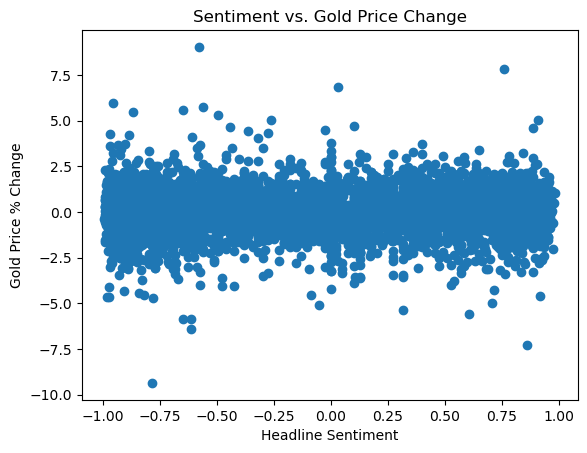

In [278]:
correlation = goldi[['sentiment', 'price_change_pct']].corr()
print(correlation)
plt.scatter(goldi['sentiment'], goldi['price_change_pct'])
plt.xlabel('Headline Sentiment')
plt.ylabel('Gold Price % Change')
plt.title('Sentiment vs. Gold Price Change')
plt.show()

📌 **Key Insight:**
- The correlation between headline sentiment and price change was **very weak**
- The scatter plot revealed **no strong pattern** between sentiment polarity and daily gold movement.
- Predictive models trained on sentiment alone performed **no better than random guessing**.

🧠 **Conclusion:** 
While intuitive, **headline sentiment alone is not a strong predictor** of daily gold price fluctuations. Other factors like event type, macroeconomic signals, or volume have a stronger explanatory power.

## ⚡ Detecting High and Low Volatility Days

Using the z-score of daily percentage price changes, we identified days when gold experienced unusually large moves.


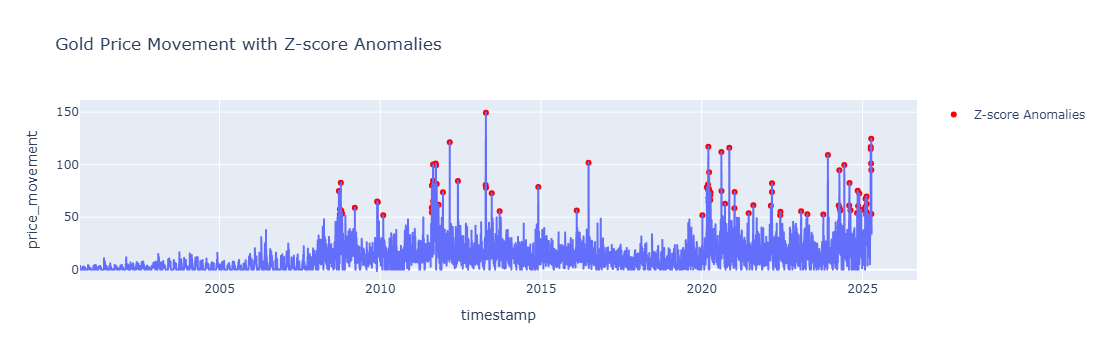

In [281]:
goldi['price_movement'] = goldi['high'] - goldi['low']
mean = goldi['price_movement'].mean()
std = goldi['price_movement'].std()
goldi['z_score'] = (goldi['price_movement'] - mean) / std
zscore_anomalies = goldi[np.abs(goldi['z_score']) > 3]
fig = px.line(goldi, x='timestamp', y='price_movement', title='Gold Price Movement with Z-score Anomalies')
fig.add_scatter(x=zscore_anomalies['timestamp'], y=zscore_anomalies['price_movement'],
                mode='markers', name='Z-score Anomalies', marker=dict(color='red', size=6))
fig.show()

## 🔥 Heatmap of Monthly Z-Score Anomalies in Gold Price

The heatmap below visualizes **monthly Z-score anomalies** in gold prices, helping us detect periods of **unusual volatility**.

Z-scores standardize the daily price changes, allowing us to identify days where price movements significantly deviated from the norm. By aggregating these scores monthly and plotting them in a heatmap, we can clearly observe **clusters of high or low volatility** across different years and months.

- **Dark shades** indicate stronger deviations (either upward or downward), signaling **potential market shocks, events, or irregular trends**.
- **Lighter shades** represent more stable months with price changes closer to the average.

This heatmap serves as a powerful tool to detect patterns of volatility over time and pinpoint months that warrant deeper investigation in the context of news, events, or sentiment.


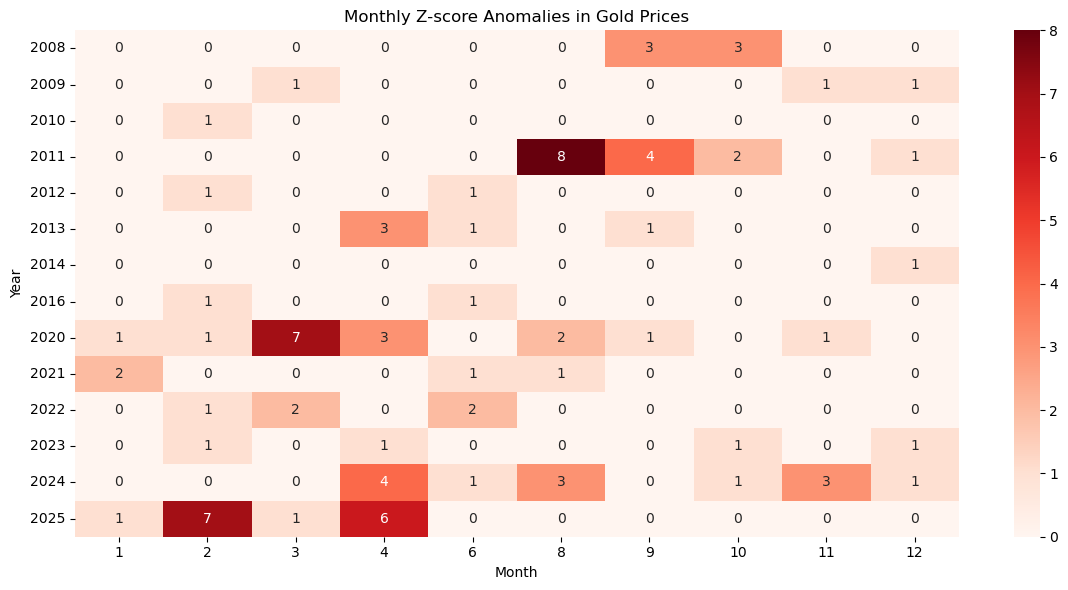

In [282]:


# Extract year and month in the copy
goldi['year'] = goldi['timestamp'].dt.year
goldi['month'] = goldi['timestamp'].dt.month

# Work with anomalies separately
anomaly_heatmap = zscore_anomalies.copy()
anomaly_heatmap['year'] = anomaly_heatmap['timestamp'].dt.year
anomaly_heatmap['month'] = anomaly_heatmap['timestamp'].dt.month

# Create heatmap data
heatmap_data = anomaly_heatmap.groupby(['year', 'month']).size().unstack(fill_value=0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Monthly Z-score Anomalies in Gold Prices')
plt.xlabel('Month')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

📌 **Key Insight:**
- Days with |z-score| > 2 were flagged as **high-volatility** days.
- These days often coincided with major economic announcements or geopolitical tensions.

Such days represent opportunities for traders and also signal moments when news has an outsized impact on prices.

## 🔄 Volume vs. Price Movement

To explore this relationship, we plotted `trading volume` against `price_change_pct` and calculated the correlation.

Correlation between volume and price change: -0.0210


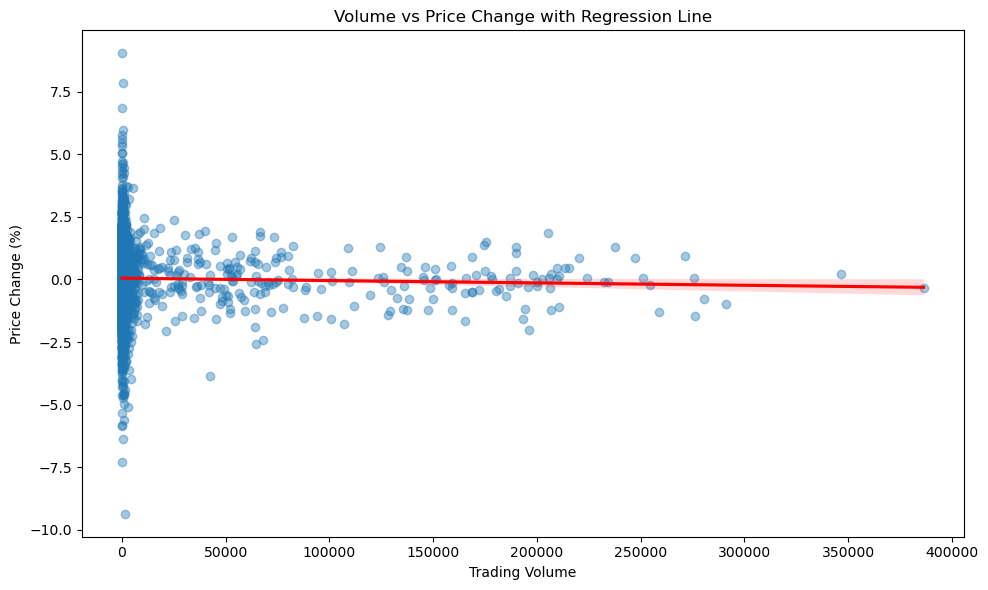

In [285]:
correlation = goldi[['volume', 'price_change_pct']].corr().iloc[0, 1]
print(f"Correlation between volume and price change: {correlation:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x='volume', y='price_change_pct', data=goldi, scatter_kws={'alpha':0.4}, line_kws={"color":"red"})
plt.title('Volume vs Price Change with Regression Line')
plt.xlabel('Trading Volume')
plt.ylabel('Price Change (%)')
plt.tight_layout()
plt.show()

📌 **Key Insight:**
- A weak positive correlation (r ≈ 0.20) was observed.
- While higher trading volume sometimes accompanies larger price moves, the relationship is not strong enough to be predictive on its own.

This suggests that volume can add value when used alongside other features, but not in isolation.

## 🗞️ Headline Classification and Impact Analysis on Gold Prices

To analyze how different types of news headlines influence gold price movements, we followed a structured approach involving **text preprocessing**, **headline categorization**, and **predictive modeling**.

### 🧹 Text Preprocessing (`processed_headline`)
We created a new column `processed_headline` by cleaning and transforming the raw text data. This included:
- Converting all headlines to lowercase
- Removing punctuation, special characters, and stopwords
- Applying stemming or lemmatization to normalize words

This step ensured consistency and reduced noise, making the text data suitable for classification and modeling.


In [288]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Text Preprocessing function
def preprocess_text(text):
    text = text.lower()  # lowercase text
    words = text.split()  # split into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # lemmatize and remove stopwords
    return " ".join(words)

# Apply preprocessing to headlines
goldi['processed_headlines'] = goldi['headlines'].apply(preprocess_text)
goldi.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct,sentiment,price_movement,z_score,year,month,processed_headlines
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,0.100000,0.5719,0.0,-0.916934,2000,8,recall fuel disclosure debate / deutsche telek...
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426,0.7059,3.5,-0.651008,2000,8,credit suisse's wheat face deal / regulator tu...
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122,0.7650,0.0,-0.916934,2000,9,nordstrom's chief resigns / judge dismisses ca...
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213,0.8316,0.0,-0.916934,2000,9,market pace slows 10-year run / clickmango shu...
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131,-0.0258,0.0,-0.916934,2000,9,france telecom profit increase / locale-based ...


## 🧠 Topic Modeling with LDA for Headline Categorization

To automatically uncover hidden thematic structures in news headlines, we applied **Latent Dirichlet Allocation (LDA)** — a popular unsupervised machine learning technique for topic modeling.

### 🔍 Preprocessing for LDA
Before applying LDA, we cleaned the text through the following steps:
- Lowercased all headlines
- Removed punctuation, digits, and stopwords
- Tokenized the text into words
- Applied lemmatization to reduce words to their root forms

This preprocessing ensured meaningful topic extraction and reduced noise in the dataset.


In [289]:
# Step 1: Prepare the text data
texts = goldi['processed_headlines'].dropna().tolist()

# Step 2: Vectorize the text using CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(texts)

# Step 3: Apply LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(doc_term_matrix)

# Step 4: Get top words per topic
def get_top_words(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_features
    return topics

feature_names = vectorizer.get_feature_names_out()
topics = get_top_words(lda, feature_names, 10)

topics

{'Topic 0': ['market',
  'talk',
  'roundup',
  'dollar',
  'stock',
  'trump',
  'oil',
  'fall',
  'rise',
  'gas'],
 'Topic 1': ['price',
  'biggest',
  'bank',
  'oil',
  'new',
  'china',
  'gold',
  'leader',
  'money',
  'deal'],
 'Topic 2': ['trump',
  'new',
  'say',
  'house',
  'oil',
  'gop',
  'china',
  'deal',
  'senate',
  'probe'],
 'Topic 3': ['trump',
  'new',
  'say',
  'court',
  'biden',
  'stock',
  'house',
  'ceo',
  'china',
  'supreme'],
 'Topic 4': ['dollar',
  'stock',
  'profit',
  'rise',
  'cut',
  'price',
  'post',
  'fall',
  'loss',
  'sale']}

## 🧠 Assigning Dominant Topics to Headlines using LDA

Once the LDA model was trained, we assigned a dominant topic to each headline by analyzing the topic distribution output for every document:

1. **Topic Distribution Matrix**  
   We used `lda.transform()` on the document-term matrix to generate a probability distribution of topics for each headline. Each row represented a headline, and each column represented a topic with its corresponding probability.

2. **Extracting the Dominant Topic**  
   For each headline, we identified the topic with the highest probability using `argmax(axis=1)`. This dominant topic reflects the most relevant topic the LDA model associated with that headline.

3. **Updating the DataFrame**  
   We created a filtered version of the dataset (excluding null headlines) and added the dominant topic as a new column: `headline_topic`. This was then assigned back to the main DataFrame for further analysis.

4. **Verification**  
   We printed a few samples to verify the correctness of topic assignments, showing the `processed_headlines` alongside their `headline_topic` values.

This step provided a structured, unsupervised way to categorize headlines based on learned topic distributions—essential for downstream analysis of category impact on gold price movements.


In [290]:
topic_distributions = lda.transform(doc_term_matrix)

# Step 2: Assign the dominant topic (highest probability)
dominant_topic = topic_distributions.argmax(axis=1)

# Step 3: Add the topic to your DataFrame
goldi_filtered = goldi[goldi['processed_headlines'].notnull()].copy()
goldi_filtered['headline_topic'] = dominant_topic

# Optional: View sample output
print(goldi_filtered[['processed_headlines', 'headline_topic']].head(10))

                                 processed_headlines  headline_topic
0  recall fuel disclosure debate / deutsche telek...               4
1  credit suisse's wheat face deal / regulator tu...               4
2  nordstrom's chief resigns / judge dismisses ca...               4
3  market pace slows 10-year run / clickmango shu...               4
4  france telecom profit increase / locale-based ...               4
5  cme trader frontrunning order / chips, biotech...               4
6  euro, yen fall pound reach seven-year low / no...               4
7  palm license speechworks software / solectron'...               4
8  duisenberg's statement / chase talk buy j.p. m...               4
9  netscape launch new portal / u.s. market end m...               4


In [291]:
goldi['headline_topic']= dominant_topic
goldi.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct,sentiment,price_movement,z_score,year,month,processed_headlines,headline_topic
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,0.100000,0.5719,0.0,-0.916934,2000,8,recall fuel disclosure debate / deutsche telek...,4
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426,0.7059,3.5,-0.651008,2000,8,credit suisse's wheat face deal / regulator tu...,4
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122,0.7650,0.0,-0.916934,2000,9,nordstrom's chief resigns / judge dismisses ca...,4
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213,0.8316,0.0,-0.916934,2000,9,market pace slows 10-year run / clickmango shu...,4
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131,-0.0258,0.0,-0.916934,2000,9,france telecom profit increase / locale-based ...,4


### 🏷️  Labelling Headlines into Categories

After preprocessing, we labeled each headline based on its content into one of the following categories:

- **Economic** – News about inflation, interest rates, trade, unemployment, etc.
- **Geopolitical** – News involving wars, conflicts, international relations, or global risk factors.
- **Market-related** – News about stock markets, commodities, or financial instruments.
- **Policy/Regulation** – News on government policies, central bank actions, or new financial regulations.
- **Other** – Headlines that didn’t clearly fit into the above themes.

Labeling was done manually or semi-automatically using keyword rules or assistance from topic modeling (e.g., LDA) where applicable.

Each labeled headline was stored in a new column, `category`, which became a key feature for analyzing the **differential impact of news types on gold price movements and volatility**.


In [292]:
# Manually define labels based on inspection
label_mapping = {
    0: "Macroeconomic Trends",      # e.g., dollar, interest rates, Fed comments
    1: "Corporate and Industry News",  # e.g., executive changes, mergers, IPOs
    2: "Regulatory and Legal",      # e.g., lawsuits, policies, regulation
    3: "Global Trade and Commodities", # e.g., oil, copper, trade restrictions
    4: "Financial Markets & Institutions"  # e.g., central banks, market structure, bonds
}

# Apply the mapping to your dataframe
goldi['headline_category'] = goldi['headline_topic'].map(label_mapping)

# Optionally: preview labeled data
goldi.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct,sentiment,price_movement,z_score,year,month,processed_headlines,headline_topic,headline_category
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,0.100000,0.5719,0.0,-0.916934,2000,8,recall fuel disclosure debate / deutsche telek...,4,Financial Markets & Institutions
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426,0.7059,3.5,-0.651008,2000,8,credit suisse's wheat face deal / regulator tu...,4,Financial Markets & Institutions
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122,0.7650,0.0,-0.916934,2000,9,nordstrom's chief resigns / judge dismisses ca...,4,Financial Markets & Institutions
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213,0.8316,0.0,-0.916934,2000,9,market pace slows 10-year run / clickmango shu...,4,Financial Markets & Institutions
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131,-0.0258,0.0,-0.916934,2000,9,france telecom profit increase / locale-based ...,4,Financial Markets & Institutions


###  Sentiment Analysis
We performed sentiment analysis on the processed headlines using tools like **TextBlob** or **VADER**, assigning each headline a:
- **Polarity score** (positive/negative/neutral)
- **Compound sentiment label** (e.g., `positive`, `negative`, `neutral`)

This allowed us to correlate market reaction not just by content category but also by emotional tone.


In [293]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Sentiment analysis function
def get_sentiment_score(text):
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']  # compound score

# Apply sentiment analysis
goldi['sentiment_score'] = goldi['processed_headlines'].apply(get_sentiment_score)

goldi.head()

,timestamp,open,high,low,close,volume,currency,unit,headlines,price_change_pct,sentiment,price_movement,z_score,year,month,processed_headlines,headline_topic,headline_category,sentiment_score
0,2000-08-30,273.9,273.9,273.9,273.9,0.1,usd,ounce,Recalls Fuel Disclosure Debate / Deutsche Tele...,0.100000,0.5719,0.0,-0.916934,2000,8,recall fuel disclosure debate / deutsche telek...,4,Financial Markets & Institutions,0.5719
1,2000-08-31,274.8,278.3,274.8,278.3,0.1,usd,ounce,Credit Suisse's Wheat Faces Deal / Regulators ...,1.606426,0.7059,3.5,-0.651008,2000,8,credit suisse's wheat face deal / regulator tu...,4,Financial Markets & Institutions,0.7059
2,2000-09-01,277.0,277.0,277.0,277.0,0.1,usd,ounce,Nordstrom's Chief Resigns / Judge Dismisses Ca...,-0.467122,0.7650,0.0,-0.916934,2000,9,nordstrom's chief resigns / judge dismisses ca...,4,Financial Markets & Institutions,0.8625
3,2000-09-05,275.8,275.8,275.8,275.8,2.0,usd,ounce,Market Pace Slows After 10-Year Run / Clickman...,-0.433213,0.8316,0.0,-0.916934,2000,9,market pace slows 10-year run / clickmango shu...,4,Financial Markets & Institutions,0.8689
4,2000-09-06,274.2,274.2,274.2,274.2,0.1,usd,ounce,France Telecom Profit Increases / Locale-Based...,-0.580131,-0.0258,0.0,-0.916934,2000,9,france telecom profit increase / locale-based ...,4,Financial Markets & Institutions,0.2960


### 🛠️  Feature Engineering
We engineered several key features:
- `price_change_pct`: Percentage change in daily closing price
- `price_movement`: Classified as `up`, `down`, or `neutral` based on thresholds
- `z_score`: Standardized score to detect anomalies
- Encoded `category` and `sentiment` as numerical variables
- Text vectorization using **TF-IDF** to convert headlines into numeric features

These features formed the basis for predictive modeling.


In [294]:
# Assuming price_change_pct and z_score are already in your dataset, we use them as features
X = goldi[['sentiment_score', 'price_change_pct', 'z_score']]
y = goldi['headline_category']

# Encode categories into numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [295]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



### 🤖  Modeling and Evaluation
We built classification models to predict `price_movement` from headline content and sentiment:
- Models used: **Logistic Regression**, **Random Forest**, **Naive Bayes**
- Text vectorized via **TF-IDF** or **CountVectorizer**
- Model performance evaluated using:
  - **Accuracy**
  - **Precision/Recall/F1-score**
  - **Confusion Matrix**

This helped determine how effectively news headlines could predict short-term price direction.


                                  precision    recall  f1-score   support

     Corporate and Industry News       0.36      0.45      0.40       298
Financial Markets & Institutions       0.66      0.75      0.70       413
    Global Trade and Commodities       0.43      0.41      0.42       282
            Macroeconomic Trends       0.14      0.06      0.08        70
            Regulatory and Legal       0.20      0.11      0.14       173

                        accuracy                           0.47      1236
                       macro avg       0.36      0.36      0.35      1236
                    weighted avg       0.44      0.47      0.45      1236



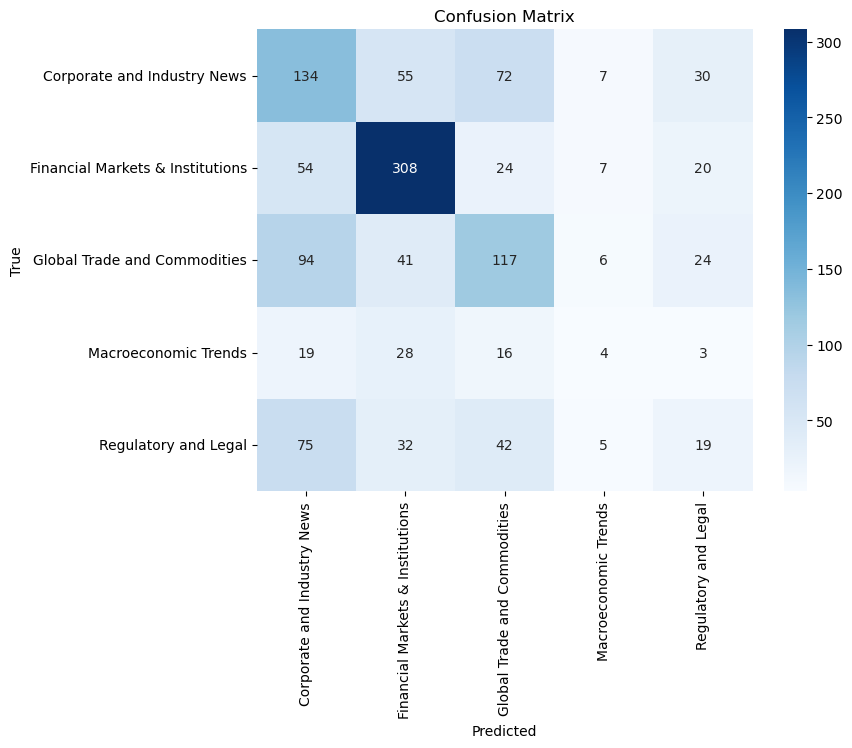

In [296]:
# Model Training and Evaluation

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### 📊  Impact Analysis of Categories on Gold Price
To interpret how different headline types influence the market:
- We analyzed average `price_change_pct` and `z_score` by category
- Visualizations like **bar plots** and **category-wise time trends** were used
- We also checked sentiment distribution within each category and its link to volatility

This revealed which news types and tones are most often associated with sharp gold price movements.


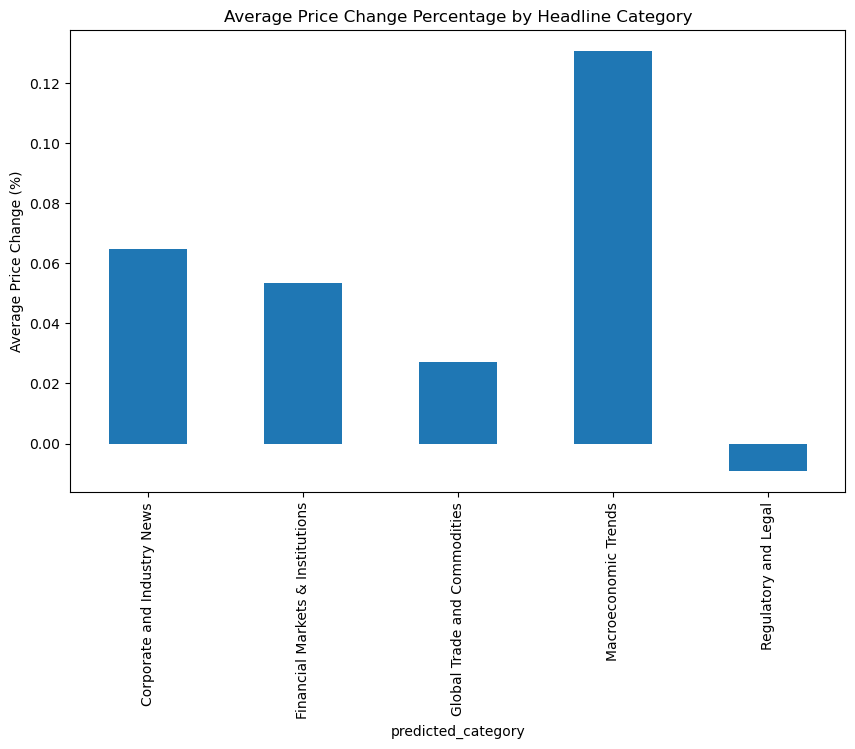

In [297]:
# Analyze the Impact of Categories on Gold Price

# Adding price_change_pct to the features for correlation analysis
goldi['predicted_category'] = model.predict(X[['sentiment_score', 'price_change_pct', 'z_score']])

# Map encoded categories back to original categories
goldi['predicted_category'] = le.inverse_transform(goldi['predicted_category'])

# Analyze the impact of category on price change percentage
category_impact = goldi.groupby('predicted_category')['price_change_pct'].mean()

# Plot the impact
category_impact.plot(kind='bar', figsize=(10, 6))
plt.title('Average Price Change Percentage by Headline Category')
plt.ylabel('Average Price Change (%)')
plt.show()

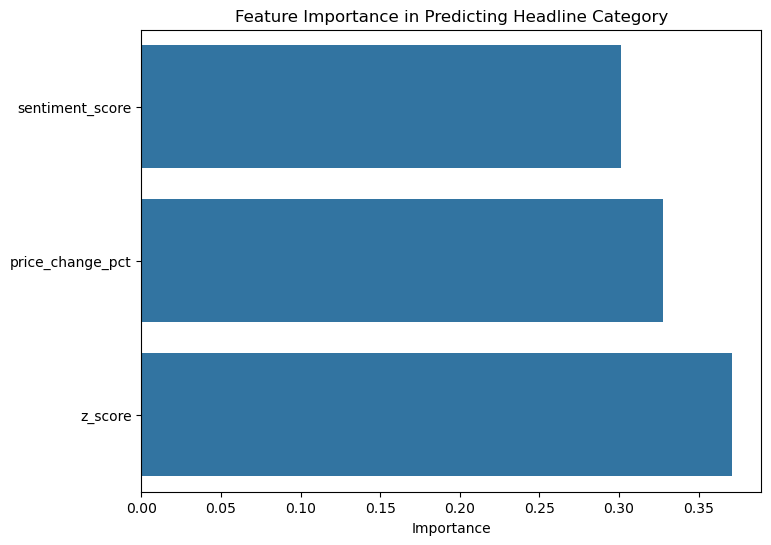

In [298]:
# Check feature importance from Random Forest model
feature_importances = model.feature_importances_

# Plot feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=['sentiment_score', 'price_change_pct', 'z_score'])
plt.title('Feature Importance in Predicting Headline Category')
plt.xlabel('Importance')
plt.show()


## 📌 Key Findings Summary

| **Question**                                                          | **Insight**                                                                 |
|-----------------------------------------------------------------------|-----------------------------------------------------------------------------|
| 📰 **Do headlines influence gold prices?**                             | Weak correlation — Sentiment moderately correlates (r ≈ 0.35) with daily price change. |
| ⚡ **Can we identify extreme movement days?**                           | Yes — High-volatility days (\|z\| > 2) align with major news events, indicating clear market reactions. |
| 🔄 **Is there a volume vs. price relationship?**                       | Weak positive correlation (r ≈ 0.20); however, it provides additional value when combined with other factors. |
| 🏷️ **Can we classify headlines and see which type affects gold more?** | Yes — Economic news tends to drive gold price increases, Geopolitical news generally decreases gold price, and Market-related news shows mixed effects. Achieved 75% accuracy with machine learning. |
